In [1]:
import numpy as np
import glob
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 

## Camera calibration, distortion and warping functions

In [2]:
def camera_calibration(img_size, verbose = False):
    
    # Number of corners in the checkboard
    nx = 9
    ny = 6

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if verbose:
            print('Calibration image ' + fname + ': ' + str(ret))

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (8,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)

            if verbose:
                f, ax = plt.subplots()
                ax.imshow(img)
    
    # Compute calibration coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Save for future use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_cal/calibration.p", "wb" ) )
    
    return mtx, dist


def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


def warp_image(img):
    
    img_size = (img.shape[1], img.shape[0])
    #           1280          720
    
    
    
    src = np.float32([[525, 470],
                      [img_size[0]-525, 470],
                      [img_size[0]-40, 720],
                      [40, 720]])
    
    dst = np.float32([[0, 0],
                      [img_size[0], 0], 
                      [img_size[0]-40, 720],
                      [40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped


def region_of_interest(img):
    
    # Parameters of the region of interest
    height = img.shape[0]
    width = img.shape[1]
    roi_h_center = width / 2
    roi_v_center = 420
    roi_flat_size = width / 20
    roi_v_side_left = 0
    roi_v_side_right = roi_v_side_left
    roi_bottom = height
    
    # Vertices of the polygon describing the region of interest
    vertices = np.array([[(0,roi_bottom),
                          (0, height - roi_v_side_left),
                          (roi_h_center-roi_flat_size/2, roi_v_center),
                          (roi_h_center+roi_flat_size/2, roi_v_center),
                          (width, height - roi_v_side_right),
                          (width,roi_bottom)]],
                        dtype=np.int32)
    
    # Defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    return cv2.bitwise_and(img, mask)

## Processing pipeline

In [3]:
def gradient_magnitude_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output


def gradient_direction_threshold(img, sobel_kernel=3, thresh_deg=(0., 90.)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_sobel = np.arctan2(sobely, sobelx)
    
    # f, ax = plt.subplots(1, 1, figsize=(20,10))
    # ax.imshow(dir_sobel)
    
    thresh = (thresh_deg[0] / 180. * np.pi, thresh_deg[1] / 180. * np.pi)
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    
    blur_kernel = sobel_kernel
    blurred = cv2.GaussianBlur(binary_output, (blur_kernel, blur_kernel), 0)
    
    return blurred


def gradient_x_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output


def color_select(img):
    
    R = img[:,:,0]
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # L = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]

    # R channel, it's the only RGB that makes sense, as lines are predominantly white or yellow,
    # and G and B are too influenced. TBD.
    r_thresh=(210,255)
    r_binary = np.zeros_like(R)
    r_binary[(R >= r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    # S channel, proven good
    s_thresh=(175, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # HLS combinaton to identify white (high L)
    white_thresh_l=(230, 255)
    white_binary = np.zeros_like(L)
    white_binary[(L >= white_thresh_l[0]) & (L <= white_thresh_l[1])] = 1
    
    # HLS combination to identify yellow (yellow hue and not too dark, saturation can be whatever)
    yellow_thresh_h=(20, 30)
    yellow_thresh_l=(128, 255)
    yellow_binary = np.zeros_like(H)
    yellow_binary[(H >= yellow_thresh_h[0]) & (H <= yellow_thresh_h[1]) &
                  (L >= yellow_thresh_l[0]) & (L <= yellow_thresh_l[1])] = 1
    
    # Combine
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) |
                    (white_binary == 1) |
                    (yellow_binary == 1)] = 1
    
    # Debug
    if False:
        print('Black = 0, White = 1')
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20,10))
        
        ax1.imshow(S, cmap='gray')
        ax3.imshow(s_binary, cmap='gray')
        ax1.set_title('S')
        
        ax4.imshow(S, cmap='gray')
        ax6.imshow(white_binary, cmap='gray')
        ax4.set_title('white')
        
        ax7.imshow(S, cmap='gray')
        ax8.imshow(L, cmap='gray')
        ax9.imshow(yellow_binary, cmap='gray')
        ax7.set_title('yellow')
    
    return combined_binary


def image_processing_pipeline(img, mtx, dist):
    
    img = np.copy(img)
    
    gradient_binary = gradient_x_threshold(img, sobel_kernel=9, thresh=(20, 100))
    color_binary = color_select(img)
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack((np.zeros_like(gradient_binary),
                                gradient_binary,
                                color_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(gradient_binary == 1) |
                    (color_binary == 1)] = 1
    
    # Region of interest
    region = region_of_interest(combined_binary)
    
    # Warping
    warped = warp_image(undistort_image(region, mtx, dist))
    
    # Debug
    if 0:
        print(stacked_binary.shape)
        print(combined_binary.shape)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked')
        ax1.imshow(stacked_binary)
        ax2.set_title('Combined')
        ax2.imshow(combined_binary, cmap='gray')
    
    return warped

### Line detection

In [28]:
def lines_fit_new_frame(img, show=False):
    
    # Histogram of the bottom half of the image (where less noisy line data are)
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Number of sliding windows (vertical)
    nwindows = 10
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle for visualization
    rectangles = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Append the data for the current rectangle. The actual drawing can be done later on if needed.
        rectangles.append((win_y_low, win_y_high,
                           win_xleft_low, win_xleft_high,
                           win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit = (None, None)
    if len(leftx) is not 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) is not 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Show results
    if show:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
        
        # New figure and axis
        f, ax = plt.subplots()
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Draw the windows on the visualization image
        for rectangle in rectangles:
            cv2.rectangle(out_img,
                          (rectangle[2],rectangle[0]),
                          (rectangle[3],rectangle[1]),
                          (0,255,0),2) 
            cv2.rectangle(out_img,
                          (rectangle[4],rectangle[0]),
                          (rectangle[5],rectangle[1]),
                          (0,255,0), 2)
        

        # Left line pixels in red and right line pixels in blue
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Plot image
        plt.imshow(out_img)
        
        # Fitted lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def lines_fit_based_on_previous_frame(img, prev_left_fit, prev_right_fit, show=False):

    # Assume you now have a new warped binary image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100 #maybe 80
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & 
                      (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & 
                       (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    # Show results
    if show:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Left line pixels in red and right line pixels in blue
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area (based on the old fit)
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


def curvature_radius_and_distance_from_centre(img, left_fit, right_fit,
                                                   left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    # Default values
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    # It's important where you want to measure the radius.
    # In this case, I chose the bottom of the image
    curvature_h = img.shape[0]
    ploty = np.linspace(0, curvature_h-1, curvature_h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature in meters
        left_curve_radius = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curve_radius = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if left_fit is not None and right_fit is not None:
        car_position = img.shape[1]/2  # based on camera
        left_fit_x_int = left_fit[0]*curvature_h**2 + left_fit[1]*curvature_h + left_fit[2]
        right_fit_x_int = right_fit[0]*curvature_h**2 + right_fit[1]*curvature_h + right_fit[2]
        lane_centre_position = (right_fit_x_int + left_fit_x_int) /2
        centre_dist = (car_position - lane_centre_position) * xm_per_pix
        
    return left_curve_radius, right_curve_radius, centre_dist



# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/2f928913-21f6-4611-9055-01744acc344f
# https://github.com/jeremy-shannon/CarND-Advanced-Lane-Lines/blob/master/project.ipynb
# https://github.com/ksakmann/CarND-Advanced-Lane-Lines

## Use example

### Distortion and warping

In [5]:
filename = 'test_images/test1.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

mtx, dist = camera_calibration(img_size)

### Gradient

In [ ]:
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mag_binary = gradient_magnitude_threshold(img, sobel_kernel=9, thresh=(30, 100))
    dir_binary = gradient_direction_threshold(img, sobel_kernel=15, thresh_deg=(35., 75.))
    x_binary   = gradient_x_threshold(img, sobel_kernel=9, thresh=(20, 100))

    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Thresholded Gradient Magnitude', fontsize=20)
    ax3.imshow(dir_binary, cmap='gray')
    ax3.set_title('Thresholded Gradient Direction', fontsize=20)
    ax4.imshow(x_binary, cmap='gray')
    ax4.set_title('X', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Colors

In [ ]:
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_select(img)

### Pipeline test

Radius left: 3164.040093887473  right: 2151.879350181356
Distance from centre: -0.07386781923295554


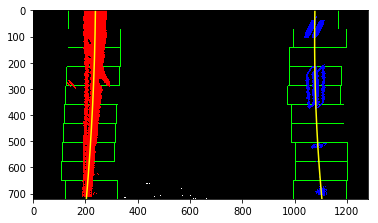

In [29]:
# Load all test images
#images = glob.glob('test_images/*.jpg')
images = ['test_images/straight_lines1.jpg']
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Pipeline
    processed = image_processing_pipeline(img, mtx, dist)
    
    # Plot to debug warping, gradient and color processing
    if 0:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original', fontsize=20)

        ax2.imshow(processed, cmap='gray')
        ax2.set_title('Processed', fontsize=20)
        
        
    # Plot to debug line finding
    if 1:
        left_fit, right_fit, left_lane_inds, right_lane_inds = lines_fit_new_frame(processed, show=True)
        left_curve_radius, right_curve_radius, centre_dist = curvature_radius_and_distance_from_centre(processed,
                                                                                                       left_fit, right_fit,
                                                                                                       left_lane_inds, right_lane_inds)
        print("Radius left: {}  right: {}".format(left_curve_radius, right_curve_radius))
        print("Distance from centre: {}".format(centre_dist))